### Загрузим данные и необходимые библиотеки

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import minimize

In [241]:
births = pd.read_csv('daily-total-female-births-in-cal.csv')
births.head()

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [242]:
passengers = pd.read_csv('international-airline-passengers.csv')
passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Визуализируем временные ряды

Text(0.5, 1.0, 'Monthly sales of company X')

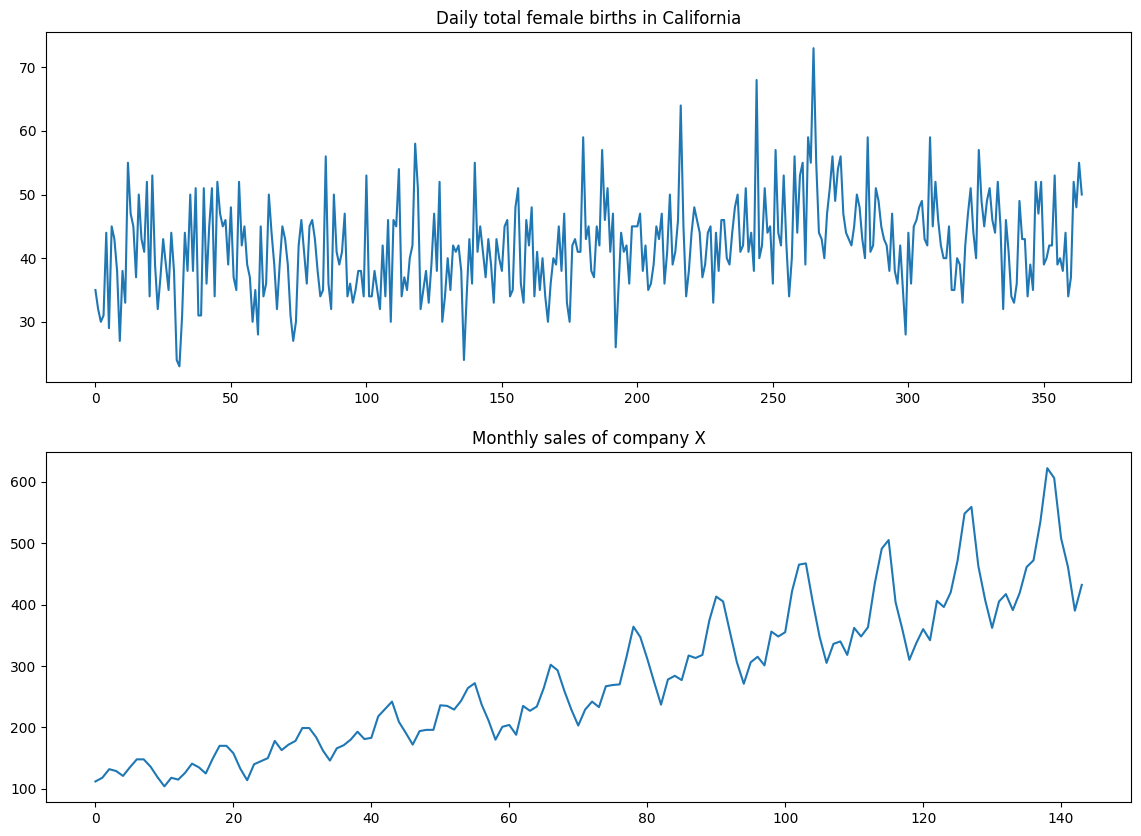

In [243]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(2, 1)

ax[0].plot(births['Count'])
ax[0].set_title('Daily total female births in California')

ax[1].plot(passengers['Count'])
ax[1].set_title('Monthly sales of company X')

### Проверим временные ряды на стационарность

In [244]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest[1])

In [245]:
test_stationarity(births['Count'])

Results of Dickey-Fuller Test:
5.2434129901498554e-05


In [246]:
test_stationarity(passengers['Count'])

Results of Dickey-Fuller Test:
0.991880243437641


Согласно результатам теста Дики-Фуллера: временной ряд отражающей ежедневное общее количество девочек, рождённых в Калифорнии является стационарным, согласно результатам теста Дики-Фуллера; а временной ряд ежемесячный объём продаж компании X стационарным не является.

In [247]:
train_births, test_births, val_births = births['Count'][:260], births['Count'][260:330], births['Count'][330:]
train_passengers, test_passengers, val_passengers = passengers['Count'][:60], passengers['Count'][60:70], passengers['Count'][70:]

### Скользящее среднее (SMA)



In [248]:
#Задаем функцию предсказывающую значения на основе скользящей средней
def sma_predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        next_val = new_series[-N:].mean()
        next_val_series = pd.Series([next_val])
        new_series = pd.concat([new_series, next_val_series], ignore_index=True)
    return new_series

In [249]:
#Задаем функцию, которая подсчитывает RMSE призаданных параметрах функции выше
def sma_rmse(n, train, test, n_pred):
    result = sma_predict(train, n, n_pred)
    predictions = result[-len(test):]
    error = root_mean_squared_error(predictions, test)
    return error

In [250]:
#Задаем функцию, которая подсчитывает находит оптимальное значение n
#для определенных данных на определенное количество предсказаний
def optimazer_sma(train, test, n_pred):
  rmse = {}
  for i in range(1, round(len(train)/2)):
    rmse[f'n: {i}'] = sma_rmse(i, train, test, n_pred)
  return min(rmse, key=rmse.get)

In [251]:
optimazer_sma(train_births, test_births, 50)

'n: 76'

In [252]:
optimazer_sma(train_passengers, test_passengers, 12)

'n: 17'

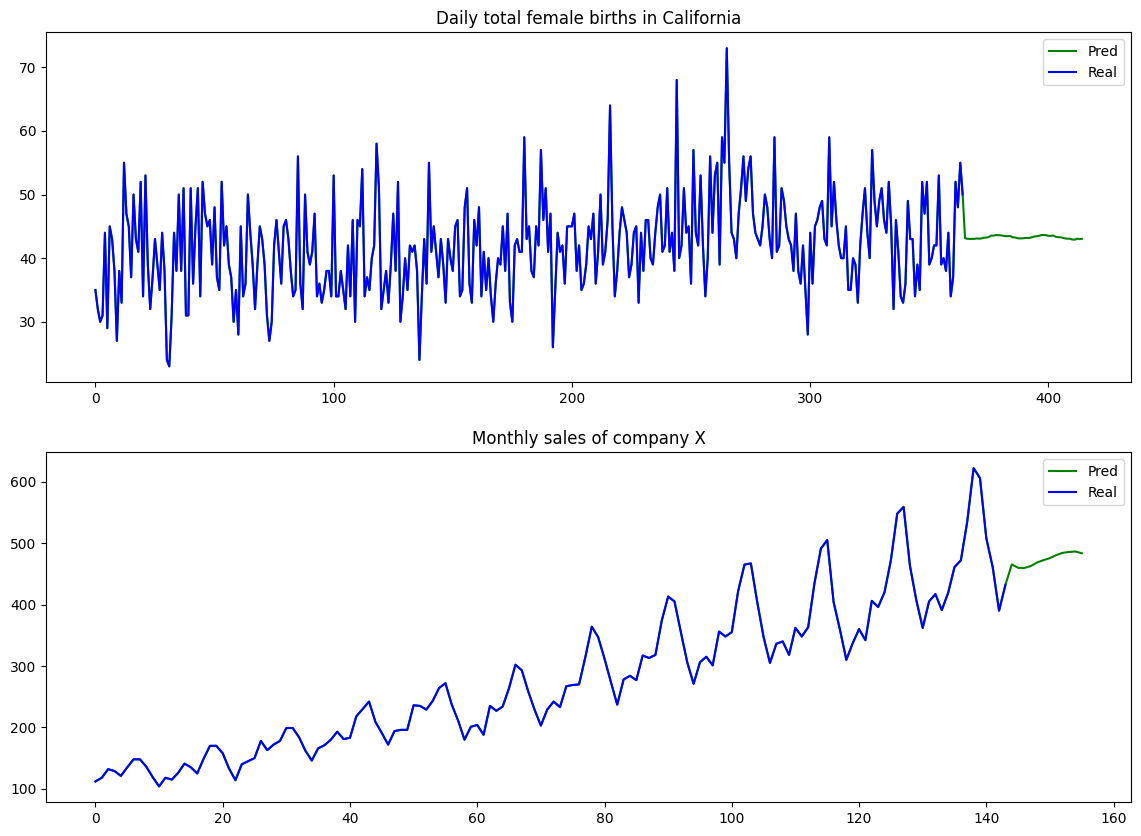

In [253]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(2, 1)

ax[0].plot(sma_predict(births['Count'], 76, 50), color='green', label='Pred')
ax[0].plot(births['Count'], color='blue', label='Real')
ax[0].set_title('Daily total female births in California')
ax[0].legend()

ax[1].plot(sma_predict(passengers["Count"], 17, 12), color='green', label='Pred')
ax[1].plot(passengers["Count"], color='blue', label='Real')
ax[1].set_title('Monthly sales of company X')
ax[1].legend()

In [254]:
result = pd.DataFrame({
    'Модель': 'MA',
    'RMSE births': [sma_rmse(76, train_births, test_births, 50)],
    'RMSE passengers': [sma_rmse(17, train_passengers, train_passengers, 12)]
})

### Экспоненциальное сглаживание (EMA)

In [255]:
#Задаем функцию предсказывающую значения на основе экспоненциального сглаживания
def ema_predict(series, alpha, n_pred=None):
    result = [series.iloc[0]]
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n-1] + (1 - alpha) * result[n-1])

    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series.iloc[-1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred - 1):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    extended_series = pd.concat([series, pd.Series(predictions)], ignore_index=True)
    return extended_series, pd.Series(result)

In [256]:
#Задаем функцию ошибки для оптимизации параметра
def ema_rmse_births(X):
    alpha = X
    result = ema_predict(train_births, alpha, len(test_births))
    predictions = result[1][-len(test_births):]
    error = root_mean_squared_error(predictions, test_births)
    return error

In [257]:
#Оптимизируем параметр
opt_births = minimize(ema_rmse_births, x0=0, method="L-BFGS-B")
alpha_opt_births = opt_births.x

In [258]:
#Задаем функцию ошибки для оптимизации параметра
def ema_rmse_passengers(X):
    alpha = X
    result = ema_predict(train_passengers, alpha, len(test_passengers))
    predictions = result[1][-len(test_passengers):]
    error = root_mean_squared_error(predictions, test_passengers)
    return error

In [259]:
#Оптимизируем параметр
opt_passengers = minimize(ema_rmse_passengers, x0=0, method="L-BFGS-B")
alpha_opt_passengers = opt_passengers.x

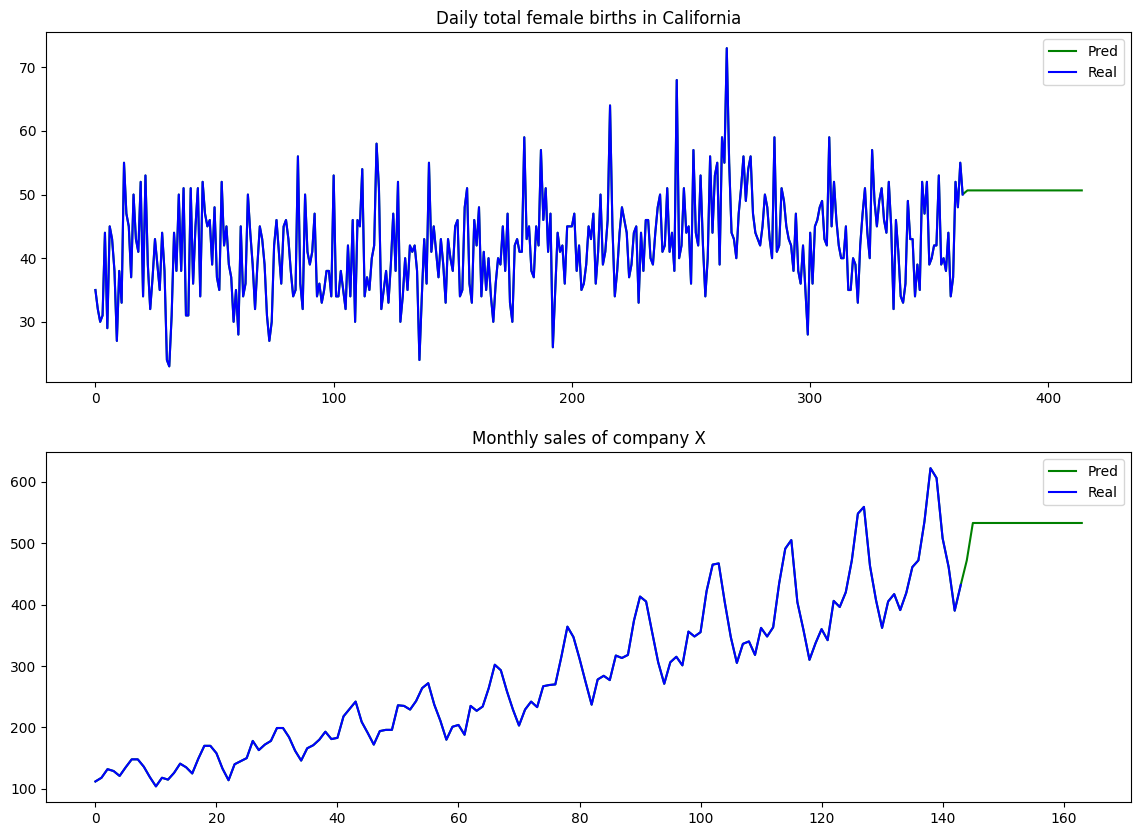

In [260]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(2, 1)

ax[0].plot(ema_predict(births['Count'], alpha_opt_births, 50)[0], color='green', label='Pred')
ax[0].plot(births['Count'], color='blue', label='Real')
ax[0].set_title('Daily total female births in California')
ax[0].legend()

ax[1].plot(ema_predict(passengers["Count"], alpha_opt_passengers, 20)[0], color='green', label='Pred')
ax[1].plot(passengers["Count"], color='blue', label='Real')
ax[1].set_title('Monthly sales of company X')
ax[1].legend()

In [261]:
new_row = pd.DataFrame({
    'Модель': 'EMA',
    'RMSE births': [ema_rmse_births(alpha_opt_births)],
    'RMSE passengers': [ema_rmse_passengers(alpha_opt_passengers)]
})
result = pd.concat([result, new_row], ignore_index=True)

### Двойное экспоненциальное сглаживание (DEMA)

In [262]:
#Задаем функцию предсказывающую значения на основе двойного экспоненциального сглаживания
def dema_predict(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.concat([series, pd.Series(preds)], ignore_index=True), pd.Series(result)

In [263]:
#Задаем функцию ошибки для оптимизации параметров
def dema_rmse_births(X):
    alpha, beta = X
    result = dema_predict(train_births, alpha, beta, len(test_births))
    predictions = result[1][-len(test_births):]
    error = root_mean_squared_error(predictions, test_births)
    return error

In [264]:
#Оптимизируем параметры
opt_births = minimize(dema_rmse_births, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt_births, beta_opt_births = opt_births.x

In [265]:
#Задаем функцию ошибки для оптимизации параметров
def dema_rmse_passengers(X):
    alpha, beta = X
    result = dema_predict(train_passengers, alpha, beta, len(test_passengers))
    predictions = result[1][-len(test_passengers):]
    error = root_mean_squared_error(predictions, test_passengers)
    return error

In [266]:
#Оптимизируем параметры
opt_passengers = minimize(dema_rmse_passengers, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt_passengers, beta_opt_passengers = opt_passengers.x

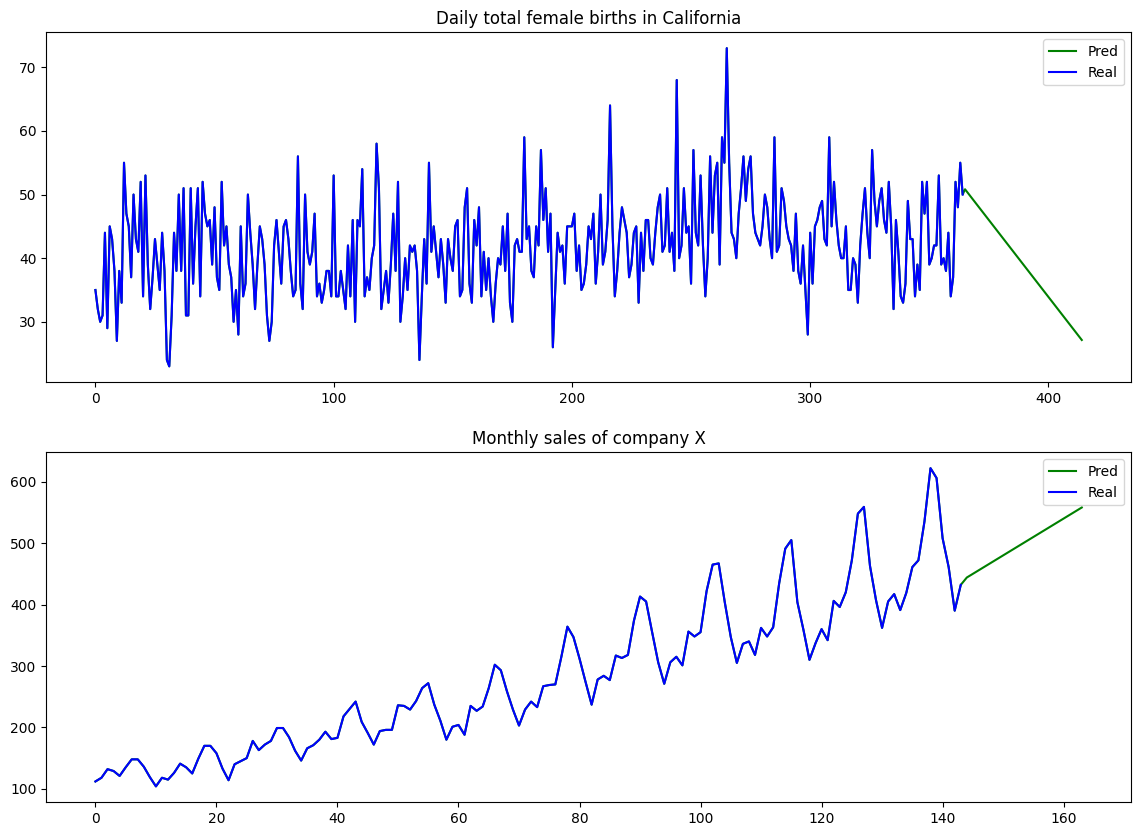

In [267]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(2, 1)

ax[0].plot(dema_predict(births['Count'], alpha_opt_births, beta_opt_births, 50)[0], color='green', label='Pred')
ax[0].plot(births['Count'], color='blue', label='Real')
ax[0].set_title('Daily total female births in California')
ax[0].legend()

ax[1].plot(dema_predict(passengers["Count"], alpha_opt_passengers, beta_opt_passengers, 20)[0], color='green', label='Pred')
ax[1].plot(passengers["Count"], color='blue', label='Real')
ax[1].set_title('Monthly sales of company X')
ax[1].legend()

In [268]:
new_row = pd.DataFrame({
    'Модель': 'DEMA',
    'RMSE births': [dema_rmse_births([alpha_opt_births, beta_opt_births])],
    'RMSE passengers': [dema_rmse_passengers([alpha_opt_passengers, beta_opt_passengers])]
})
result = pd.concat([result, new_row], ignore_index=True)

### Тройное экспоненциальное сглаживание (TEMA)

In [269]:
#Задаем функцию, определяющую тренд
def initial_trend(i, series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [270]:
#Задаем функцию, определяющую сезонность
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [271]:
#Задаем функцию предсказывающую значения на основе тройного экспоненциального сглаживания
def tema_predict(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(i, series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [272]:
#Задаем функцию ошибки для оптимизации параметров
def tema_rmse_births(X):
    alpha, beta, gamma = X
    result = tema_predict(train_births, 12, alpha, beta, gamma, len(test_births))
    predictions = result[-len(test_births):]
    error = root_mean_squared_error(predictions, test_births)
    return error

In [273]:
#Оптимизируем параметры
opt_births = minimize(tema_rmse_births, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt_births, beta_opt_births, gamma_opt_births = opt_births.x

In [274]:
#Задаем функцию ошибки для оптимизации параметров
def tema_rmse_passengers(X):
    alpha, beta, gamma = X
    result = tema_predict(train_passengers, 12, alpha, beta, gamma, len(test_passengers))
    predictions = result[-len(test_passengers):]
    error = root_mean_squared_error(predictions, test_passengers)
    return error

In [275]:
#Оптимизируем параметры
opt_passengers = minimize(tema_rmse_passengers, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt_passengers, beta_opt_passengers, gamma_opt_passengers = opt_passengers.x

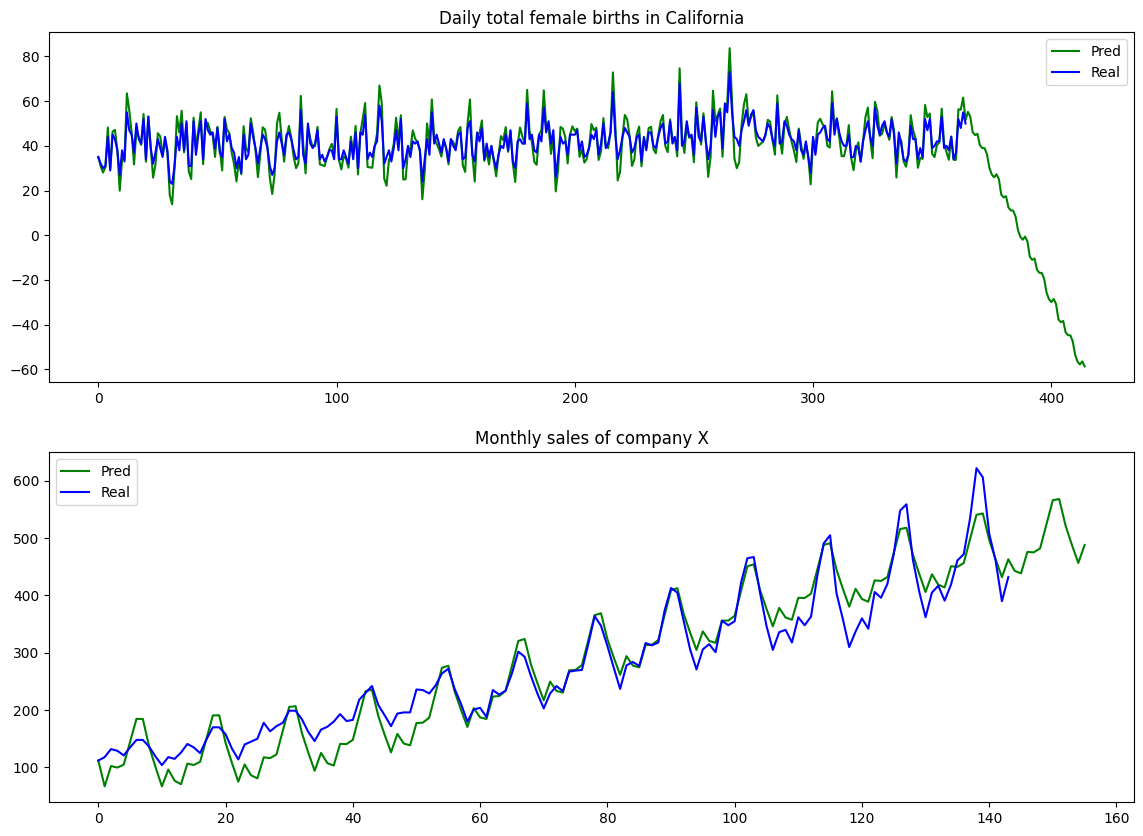

In [276]:
fig = plt.figure(figsize=(14, 10))
ax = fig.subplots(2, 1)

ax[0].plot(tema_predict(births['Count'], 12, alpha_opt_births, beta_opt_births, gamma_opt_births, 50), color='green', label='Pred')
ax[0].plot(births['Count'], color='blue', label='Real')
ax[0].set_title('Daily total female births in California')
ax[0].legend()

ax[1].plot(tema_predict(passengers["Count"], 12, alpha_opt_passengers, beta_opt_passengers, gamma_opt_passengers, 12), color='green', label='Pred')
ax[1].plot(passengers["Count"], color='blue', label='Real')
ax[1].set_title('Monthly sales of company X')
ax[1].legend()

In [277]:
new_row = pd.DataFrame({
    'Модель': 'TEMA',
    'RMSE births': [tema_rmse_births([alpha_opt_births, beta_opt_births, gamma_opt_births])],
    'RMSE passengers': [tema_rmse_passengers([alpha_opt_passengers, beta_opt_passengers, gamma_opt_passengers])]
})
result = pd.concat([result, new_row], ignore_index=True)

### Результаты

In [278]:
result

,Модель,RMSE births,RMSE passengers
0,MA,8.450280,27.092565
1,EMA,7.307837,33.970396
2,DEMA,7.030083,27.035162
3,TEMA,7.116921,13.249624


Стационарный ряд:

Все модели показывают достаточно низкую ошибку. Однако модели двойного и тройного сглаживания обнаруживают в ряду тренд и повторяют его на предсказанных значениях из-за чего плохо подходят для предсказания его значений. Классическое экспоненциальное сглаживание и скользящее среднее на предсказанных значениях выходят на плато из-за чего поддходят только для предсказания нескольких ближайших значений. При этом скользящее среднее медленнеевыходит на плато и приближается к среднему значению временного ряда, благожаря чему являетсялучшей моделью дляпредсказания значений этого ряда

Нестационарный ряд:

Поскольку в представленном ряду наблюдаются и тренд и сезонность, то лучшей моделью для предсказания его значений является моддель тройного экспоненциального сглаживания, что подтверждается наименьшим значением ошибки и повторением сезонности и тренда в предсказанных значениях